<a href="https://colab.research.google.com/github/aimanmanlai/DeepFake/blob/main/DeepFake_VGGFace16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [2]:
!pip install keras_vggface
!pip install opencv-python
!pip install --user tqdm
!pip install Keras-Applications

     |████████████████████████████████| 51kB 4.4MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def random_crop(image,h=200,w=150):
     height, width = image.shape[:2]
     random_array = numpy.random.random(size=4);
     #x = int(random_array[2] * (width-w))
     #y = int(random_array[3] * (height-h))
     x = 105
     y = 50
     image_crop = image[y:h+y, x:w+x, 0:3]
     image_crop = resize(image_crop, image.shape)
     return image_crop
    

# New Section

In [5]:

import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import metrics

from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
#from keras.callbacks.callbacks import ReduceLROnPlateau

from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1 import ConfigProto

from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [7]:
base_path = '/content/drive/MyDrive/deepfake/'
image_gen = ImageDataGenerator(rescale=1./255.)
batch_size = 32

train_flow = image_gen.flow_from_directory(
    base_path + 'task1/development/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

valid_flow = image_gen.flow_from_directory(
    base_path + 'task1/validation/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_flow = image_gen.flow_from_directory(
    base_path + 'task2/evaluation/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

Found 760 images belonging to 2 classes.
Found 120 images belonging to 1 classes.
Found 600 images belonging to 2 classes.


In [8]:
train_flow.class_indices

{'fake': 0, 'real': 1}

In [9]:
valid_flow.class_indices

{'fake': 0}

In [10]:
test_flow.class_indices

{'fake': 0, 'real': 1}

In [11]:

"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
    
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [12]:
vgg_model = VGGFace(include_top=False, input_shape = (224,224,3))

last_layer = vgg_model.get_layer('pool5').output
flat_layer = Flatten(name='flatten')(last_layer)
fc1 = Dense(2048, activation='relu', name='fc1')(flat_layer)
dense2 = Dense(1, activation='sigmoid', name='dense2')(fc1)

custom_vgg_model = Model(vgg_model.input, dense2)

58916864/58909280 [==============================] - 1s 0us/step


In [13]:
custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0     

In [14]:
custom_vgg_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002), 
    metrics=['acc']
)

In [15]:
train_steps = 400//batch_size
valid_steps = 50//batch_size

history = custom_vgg_model.fit_generator(
    train_flow,
    epochs=5,
    steps_per_epoch=train_steps,
    validation_data=valid_flow,
    validation_steps=valid_steps
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
12/12 [==============================] - 165s 11s/step - loss: 0.6673 - acc: 0.5252 - val_loss: 0.3004 - val_acc: 1.0000
Epoch 2/5
12/12 [==============================] - 56s 5s/step - loss: 0.5173 - acc: 0.6512 - val_loss: 0.0678 - val_acc: 1.0000
Epoch 3/5
12/12 [==============================] - 30s 2s/step - loss: 0.1110 - acc: 0.9448 - val_loss: 0.0545 - val_acc: 0.9688
Epoch 4/5
12/12 [==============================] - 13s 1s/step - loss: 0.1185 - acc: 0.9514 - val_loss: 3.7325e-04 - val_acc: 1.0000
Epoch 5/5
12/12 [==============================] - 8s 673ms/step - loss: 0.0910 - acc: 0.9771 - val_loss: 0.0037 - val_acc: 1.0000


In [16]:
custom_vgg_model.save('vggface_v1.h5')

In [17]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [18]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [19]:
#acc = history.history['acc']
#val_accuracy = history.history['val_accuracy']
#loss = history.history['loss']
#val_loss = history.history['val_loss']

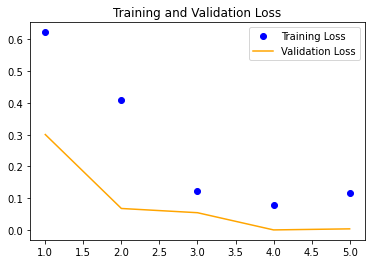

In [20]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)

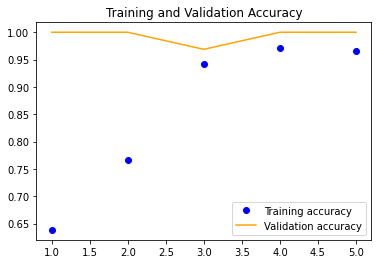

In [22]:
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [23]:
y_pred = custom_vgg_model.predict(test_flow)
y_test = test_flow.classes

In [24]:
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC-AUC Score: 0.574388888888889
AP Score: 0.5854769781516498

              precision    recall  f1-score   support

           0       0.48      0.19      0.27       300
           1       0.50      0.80      0.61       300

    accuracy                           0.49       600
   macro avg       0.49      0.49      0.44       600
weighted avg       0.49      0.49      0.44       600

